# Car Price Prediction
## Exploratory Data Analysis

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, concat_ws, when
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import matplotlib.style as style
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import numpy as np
from scipy import stats
from pyspark.ml.evaluation import RegressionEvaluator
import warnings

In [ ]:
warnings.filterwarnings('ignore')
spark = SparkSession.builder.appName('CarPricePedictions').getOrCreate()

In [3]:
# read the dataset
carData = spark.read.option("header", "true").csv("car_price_dataset.csv")

In [4]:
# check the data types
carData.describe()

DataFrame[summary: string, Brand: string, Model: string, Year: string, Engine_Size: string, Fuel_Type: string, Transmission: string, Mileage: string, Doors: string, Owner_Count: string, Price: string]

In [5]:
# convert the data types to the apporiate ones
integerCols = ["Year", "Mileage", "Doors", "Owner_Count"]
carData = carData.select([col(c).cast(IntegerType()).alias(c) if c in integerCols else col(c) for c in carData.columns])


doubleCols = ["Engine_Size", "Price"]
carData = carData.select([col(c).cast(DoubleType()).alias(c) if c in doubleCols else col(c) for c in carData.columns])

In [6]:
# get a preview of the dataset
carData.show(5)

+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-------+
|     Brand| Model|Year|Engine_Size|Fuel_Type|  Transmission|Mileage|Doors|Owner_Count|  Price|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-------+
|       Kia|   Rio|2020|        4.2|   Diesel|        Manual| 289944|    3|          5| 8501.0|
| Chevrolet|Malibu|2012|        2.0|   Hybrid|     Automatic|   5356|    2|          3|12092.0|
|  Mercedes|   GLA|2020|        4.2|   Diesel|     Automatic| 231440|    4|          2|11171.0|
|      Audi|    Q5|2023|        2.0| Electric|        Manual| 160971|    2|          1|11780.0|
|Volkswagen|  Golf|2003|        2.6|   Hybrid|Semi-Automatic| 286618|    3|          3| 2867.0|
+----------+------+----+-----------+---------+--------------+-------+-----+-----------+-------+
only showing top 5 rows



In [7]:
# check for missing data
carData.select([sum(col(c).isNull().cast("int")).alias(c) for c in carData.columns]).show()

+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
|Brand|Model|Year|Engine_Size|Fuel_Type|Transmission|Mileage|Doors|Owner_Count|Price|
+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+
|    0|    0|   0|          0|        0|           0|      0|    0|          0|    0|
+-----+-----+----+-----------+---------+------------+-------+-----+-----------+-----+



In [8]:
# check for duplicated data
initalObservationCount = carData.count()
uniqueObservationCount = carData.distinct().count()

duplicateCount = initalObservationCount - uniqueObservationCount
print("Number of Duplicates: " + str(duplicateCount))

Number of Duplicates: 0


In [9]:
# get an overview of the data
carData.summary().show()

25/04/12 20:02:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|summary|     Brand|   Model|             Year|       Engine_Size|Fuel_Type|  Transmission|          Mileage|            Doors|       Owner_Count|             Price|
+-------+----------+--------+-----------------+------------------+---------+--------------+-----------------+-----------------+------------------+------------------+
|  count|     10000|   10000|            10000|             10000|    10000|         10000|            10000|            10000|             10000|             10000|
|   mean|      NULL|    NULL|        2011.5437|3.0005599999999966|     NULL|          NULL|      149239.1118|           3.4971|            2.9911|         8852.9644|
| stddev|      NULL|    NULL|6.897698756455926|1.1493240539456635|     NULL|          NULL|86322.34895733812|1.110096762215867|1.4226816904421142|3112.5968102892775|
|   

### Data Visualizations

#### Visualization of the Car Price

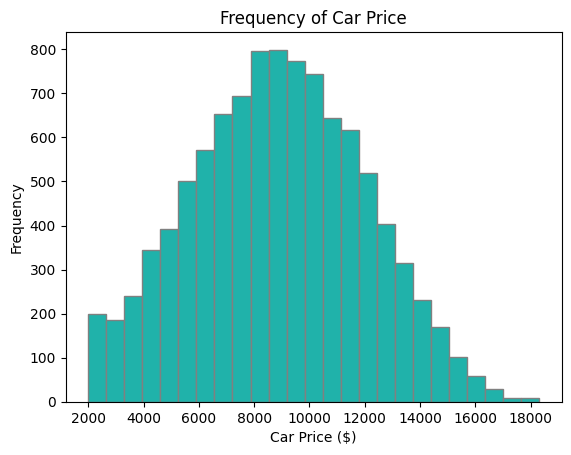

In [10]:
# define the histogram of car prices
carPriceHistogram = carData.select("Price").rdd.flatMap(lambda x: x).histogram(25)
binEdges, frequencies = carPriceHistogram

# plot the histogram
plt.hist(binEdges[:-1], bins=binEdges, weights=frequencies, color = "lightseagreen", edgecolor = "grey")
plt.xlabel("Car Price ($)")
plt.ylabel("Frequency")
plt.title("Frequency of Car Price")
plt.show()

#### Visualization of Quantitative Predictors

In [11]:
# collect the data
carDataCollect = carData.collect()

# define the target variable
carPrices = [row["Price"] for row in carDataCollect]

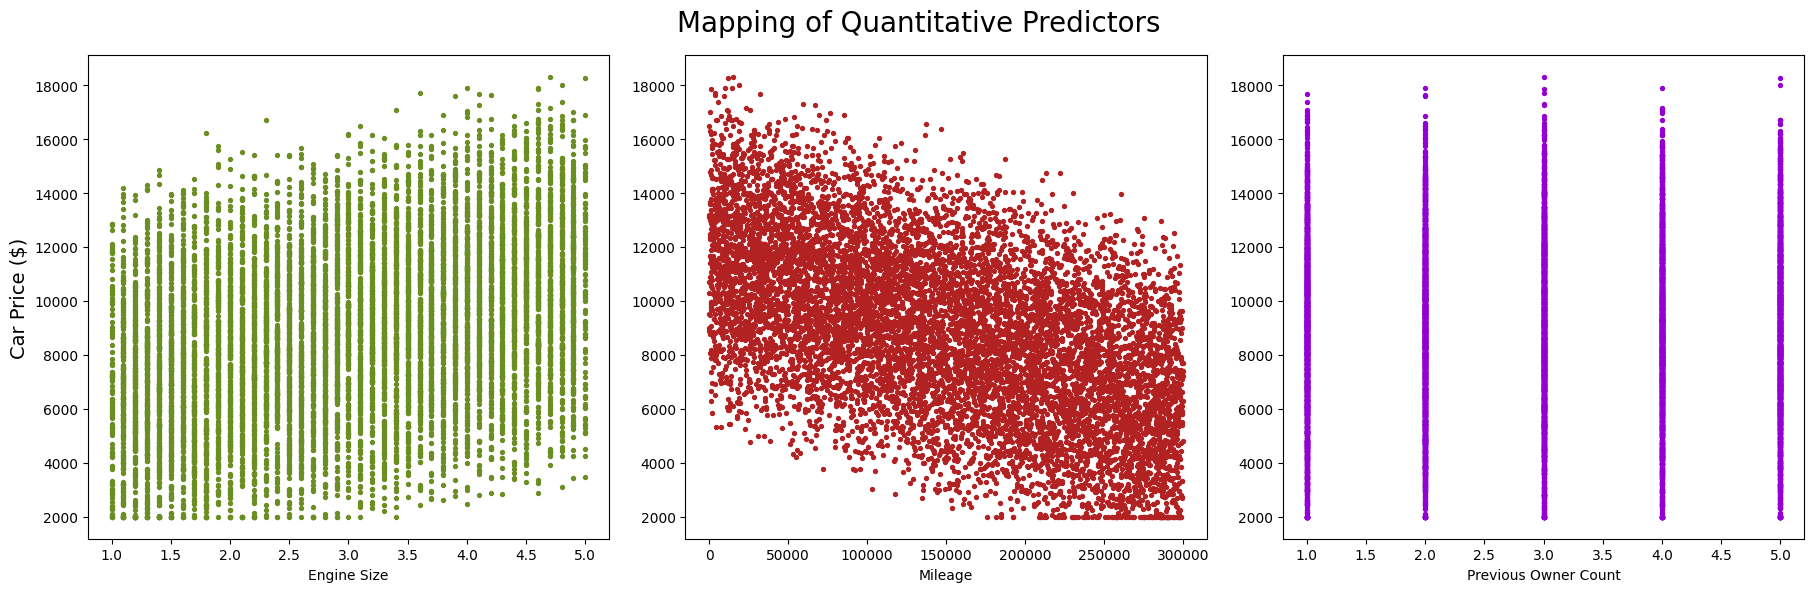

In [12]:
# collect the quantitative predictors
engineSize = [row["Engine_Size"] for row in carDataCollect]
mileage = [row["Mileage"] for row in carDataCollect]
ownerCount = [row["Owner_Count"] for row in carDataCollect]

# create a grid for multiple plots
fig, axs = plt.subplots(1, 3, figsize = (18, 6))

# plot a scatterplot of engine size
axs[0].scatter(engineSize, carPrices, s = 8, color = "olivedrab")
axs[0].set_xlabel("Engine Size")

# plot a scatterplot of mileage
axs[1].scatter(mileage, carPrices, s = 8, color = "firebrick")
axs[1].set_xlabel("Mileage")

# plot a scatterplot of owner count
axs[2].scatter(ownerCount, carPrices, s = 8, color = "darkviolet")
axs[2].set_xlabel("Previous Owner Count")



fig.suptitle("Mapping of Quantitative Predictors", fontsize = 20)
fig.text(0.0002, 0.5, "Car Price ($)", ha= "center", va= "center", rotation= "vertical", fontsize=14)

plt.tight_layout()
plt.show()

#### Visualization of Qualitative Predictors

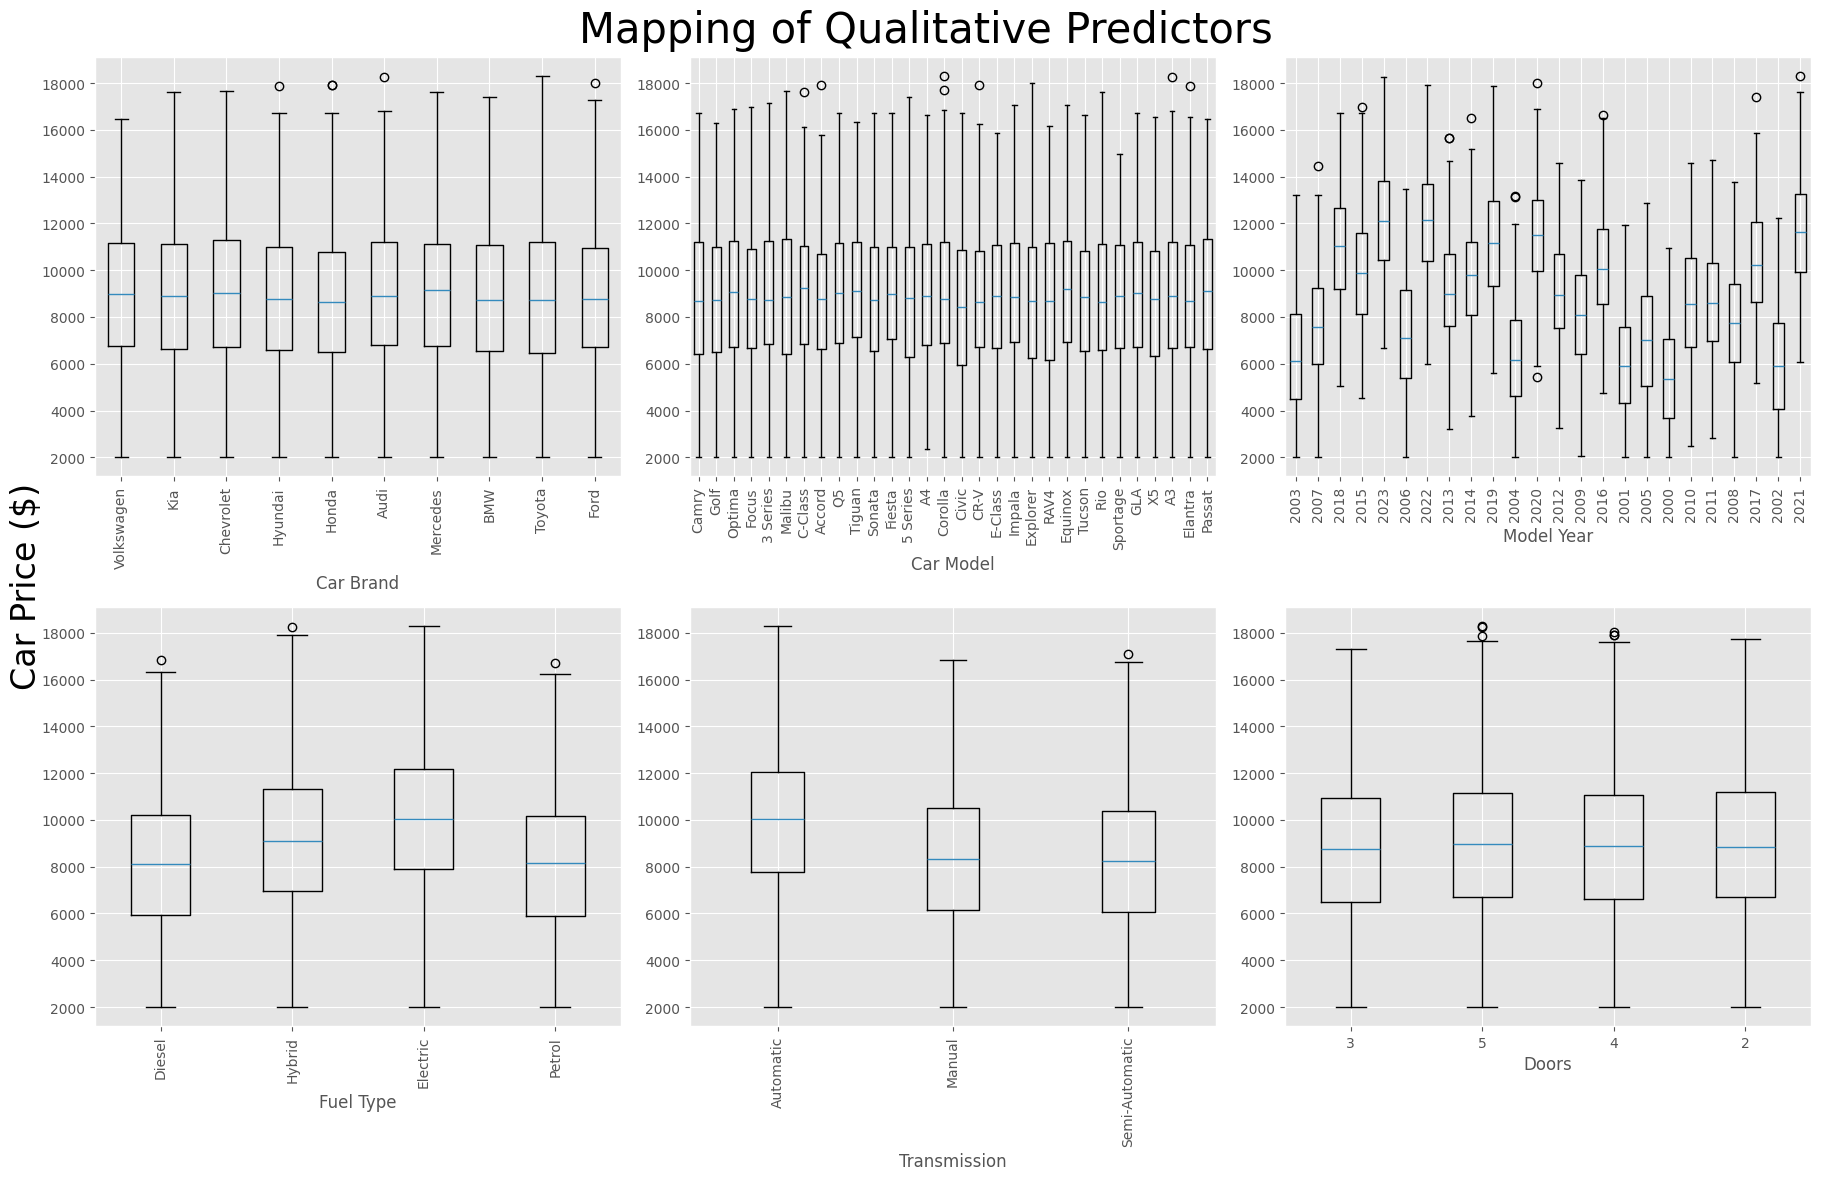

In [13]:
style.use('ggplot')

# create a grid for the boxplots
fig, axs = plt.subplots(2, 3, figsize = (18, 12))

# subset the qualitative predictors
qualitativePredictors = ["Brand", "Model", "Year", "Fuel_Type", "Transmission", "Doors"]
qualitativeData = carData.select(*qualitativePredictors, "Price")

# plot the car brands
groupedBrand = qualitativeData.groupBy("Brand").agg(F.collect_list("Price").alias("Price")).collect()
df_brandPlot = [row["Price"] for row in groupedBrand]


axs[0][0].boxplot(df_brandPlot)
axs[0][0].set_xticks(range(1, len(df_brandPlot) + 1), [row["Brand"] for row in groupedBrand], rotation = 90)
axs[0][0].set_xlabel("Car Brand")


# plot the car models
groupedModel = qualitativeData.groupBy("Model").agg(F.collect_list("Price").alias("Price")).collect()
df_carModelPlot = [row["Price"] for row in groupedModel]


axs[0][1].boxplot(df_carModelPlot)
axs[0][1].set_xticks(range(1, len(df_carModelPlot) + 1), [row['Model'] for row in groupedModel], rotation = 90)
axs[0][1].set_xlabel("Car Model")

# plot the model years
groupedYear = qualitativeData.groupBy("Year").agg(F.collect_list("Price").alias("Price")).collect()
df_yearPlot = [row["Price"] for row in groupedYear]


axs[0][2].boxplot(df_yearPlot)
axs[0][2].set_xticks(range(1, len(df_yearPlot) + 1), [row['Year'] for row in groupedYear], rotation = 90)
axs[0][2].set_xlabel("Model Year")

# plot the fuel types
groupedFuel = qualitativeData.groupBy("Fuel_Type").agg(F.collect_list("Price").alias("Price")).collect()
df_fuelPlot = [row["Price"] for row in groupedFuel]


axs[1][0].boxplot(df_fuelPlot)
axs[1][0].set_xticks(range(1, len(df_fuelPlot) + 1), [row["Fuel_Type"] for row in groupedFuel], rotation = 90)
axs[1][0].set_xlabel("Fuel Type")

# plot the transmission types
groupedTransmission = qualitativeData.groupBy("Transmission").agg(F.collect_list("Price").alias("Price")).collect()
df_transmissionPlot = [row["Price"] for row in groupedTransmission]


axs[1][1].boxplot(df_transmissionPlot)
axs[1][1].set_xticks(range(1, len(df_transmissionPlot) + 1), [row["Transmission"] for row in groupedTransmission], rotation = 90)
axs[1][1].set_xlabel("Transmission")

# plot the door count
groupedDoors = qualitativeData.groupBy("Doors").agg(F.collect_list("Price").alias("Price")).collect()
df_doorsPlot = [row["Price"] for row in groupedDoors]


axs[1][2].boxplot(df_doorsPlot)
axs[1][2].set_xticks(range(1, len(df_doorsPlot) + 1), [row["Doors"] for row in groupedDoors], rotation = 0)
axs[1][2].set_xlabel("Doors")

fig.suptitle("Mapping of Qualitative Predictors", fontsize = 30)
fig.text(0.0002, 0.5, "Car Price ($)", ha= "center", va= "center", rotation= "vertical", fontsize=24)

plt.tight_layout()
plt.show()

### Configure the Data for Model Building

The brand and model attributes are related to each other. Therefore, an interaction needs to be made.

In [14]:
# create the interaction between the car brand and model
carData = carData.withColumn("Make and Model", concat_ws("-", "Brand", "Model"))

# drop the original columns
carData = carData.drop("Brand", "Model")

#### Create Dummy Variables

In [15]:
# create dummy variables for make and model
uniqueMakeModel = [row["Make and Model"] for row in carData.select("Make and Model").distinct().collect()]

for makeAndModel in uniqueMakeModel:
    carData = carData.withColumn(f"Make and Model_{makeAndModel}", when(carData["Make and Model"] == makeAndModel, 1).otherwise(0))

## drop the first dummy
firstDummy_makeModel = f"Make and Model_{uniqueMakeModel[0]}"
print(f"Baseline: {firstDummy_makeModel}")
carData = carData.drop(firstDummy_makeModel)
carData = carData.drop("Make and Model")


# create dummy variables for year
uniqueYear = [row["Year"] for row in carData.select("Year").distinct().collect()]

for year in uniqueYear:
    carData = carData.withColumn(f"Year_{year}", when(carData["Year"] == year, 1).otherwise(0))

## drop the first dummy
firstDummy_year = f"Year_{uniqueYear[0]}"
print(f"Baseline: {firstDummy_year}")
carData = carData.drop(firstDummy_year)
carData = carData.drop("Year")


# create dummy variables for fuel
uniqueFuel = [row["Fuel_Type"] for row in carData.select("Fuel_Type").distinct().collect()]

for fuel in uniqueFuel:
    carData = carData.withColumn(f"Fuel_Type_{fuel}", when(carData["Fuel_Type"] == fuel, 1).otherwise(0))

## drop the first dummy
firstDummy_fuel = f"Fuel_Type_{uniqueFuel[0]}"
print(f"Baseline: {firstDummy_fuel}")
carData = carData.drop(firstDummy_fuel)
carData = carData.drop("Fuel_Type")

# create dummy variables for transmission
uniqueTransmission = [row["Transmission"] for row in carData.select("Transmission").distinct().collect()]

for transmission in uniqueTransmission:
    carData = carData.withColumn(f"Transmission_{transmission}", when(carData["Transmission"] == transmission, 1).otherwise(0))

## drop the first dummy
firstDummy_transmission = f"Transmission_{uniqueTransmission[0]}"
print(f"Baseline: {firstDummy_transmission}")
carData = carData.drop(firstDummy_transmission)
carData = carData.drop("Transmission")

# create dummy variables for doors
uniqueDoors = [row["Doors"] for row in carData.select("Doors").distinct().collect()]

for doors in uniqueDoors:
    carData = carData.withColumn(f"Doors_{doors}", when(carData["Doors"] == doors, 1).otherwise(0))

## drop the first dummy
firstDummy_doors = f"Doors_{uniqueDoors[0]}"
print(f"Baseline: {firstDummy_doors}")
carData = carData.drop(firstDummy_doors)
carData = carData.drop("Doors")

Baseline: Make and Model_BMW-3 Series
Baseline: Year_2003
Baseline: Fuel_Type_Diesel
Baseline: Transmission_Automatic
Baseline: Doors_3


#### Split the Data
We will split the data to use 70% for training, 15% for testing, and 15% for validation.

In [16]:
# create the testing data
trainData, remainingData = carData.randomSplit([.7, .3], seed = 1235)
# create the testing and validation data
testData, validationData = remainingData.randomSplit([.5, .5], seed = 1235)

### Reduced Linear Regression Model

We first need the full linear regression model to use as a baseline.

In [17]:
# define the predictors
predictors = [col for col in carData.columns if col != "Price"]
assembler = VectorAssembler(inputCols = predictors, outputCol = "predictors")
assembledData = assembler.transform(trainData)

In [18]:
# fit and train the linear regression model
lr = LinearRegression(featuresCol = "predictors", labelCol="Price")
fullModel = lr.fit(assembledData)

25/04/12 20:02:56 WARN Instrumentation: [4d4c3791] regParam is zero, which might cause numerical instability and overfitting.
25/04/12 20:02:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/12 20:02:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/04/12 20:02:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [19]:
# get number of parameters including intercept
fullModelParameters = len(trainData.columns)

In [20]:
# compute R^{2}
r2FullModel = fullModel.summary.r2
print("R^{2} Value:")
print(r2FullModel)

R^{2} Value:
0.9993537920589735


In [21]:
# calculate the RSS to use for ANOVA testing
fullModelPredictions = fullModel.transform(assembledData)
fullModelPredictions = fullModelPredictions.withColumn("residual", col("Price") - col("prediction"))
fullModelPredictions = fullModelPredictions.withColumn("squared_residual", col("residual") ** 2)

fullModel_RSS = fullModelPredictions.agg({"squared_residual": "sum"}).collect()[0][0]

For the full model with $R^{2} = 0.999$ indicates that the model may have an overfitting issue.

In [22]:
# get the ccefficients and standard errors
coefficients = fullModel.coefficients
standardErrors = np.sqrt(fullModel.summary.coefficientStandardErrors)

standardErrors = standardErrors[:-1]

# compute the tStats
tStat = coefficients / standardErrors

# compute the p-values
pValues = 2 * (1 - stats.t.cdf(np.abs(tStat), df= fullModel.summary.degreesOfFreedom))

# print the p-values
predictorName = [col for col in trainData.columns if col != "Price"]
for i in range(len(pValues)):
  print(f"p-value for {predictorName[i]}: {pValues[i]}")

p-value for Engine_Size: 0.0
p-value for Mileage: 2.15564988081951e-09
p-value for Owner_Count: 0.8147788384760557
p-value for Make and Model_Audi-A4: 0.016578973445482204
p-value for Make and Model_Chevrolet-Equinox: 0.2078109925786198
p-value for Make and Model_Chevrolet-Malibu: 0.8525277737231693
p-value for Make and Model_Hyundai-Elantra: 0.43564847907133286
p-value for Make and Model_Honda-CR-V: 0.07295560878988239
p-value for Make and Model_Ford-Fiesta: 0.9891047279335816
p-value for Make and Model_Honda-Accord: 0.005190985597637976
p-value for Make and Model_BMW-5 Series: 0.0091587839308096
p-value for Make and Model_Toyota-Camry: 0.005366369661138348
p-value for Make and Model_Hyundai-Tucson: 0.03458680417216686
p-value for Make and Model_Mercedes-C-Class: 0.02411341220357066
p-value for Make and Model_Ford-Focus: 0.7813689388263481
p-value for Make and Model_Mercedes-E-Class: 0.11824333317409996
p-value for Make and Model_Volkswagen-Tiguan: 0.9400475557468677
p-value for Make 

When $p-value \leq 0.001$, the predictor is statistically significant. If the predictor isn't statistically significant, then the predictor shall be dropped from the model.

In [23]:
# determine the predictors that are statistically significant
significantPredictors = [predictorName[i] for i in range(len(pValues)) if pValues[i] <= 0.001]
significantPredictors.append("Price")

# need to reduce the training and testing dataset
trainDataReduced = trainData.select(*significantPredictors)
testDataReduced = testData.select(*significantPredictors)

# see what is the significant predictors
print("Significant Predictors with Price")
significantPredictors

Significant Predictors with Price


['Engine_Size',
 'Mileage',
 'Make and Model_Honda-Civic',
 'Year_2007',
 'Year_2018',
 'Year_2015',
 'Year_2023',
 'Year_2006',
 'Year_2022',
 'Year_2013',
 'Year_2014',
 'Year_2019',
 'Year_2004',
 'Year_2020',
 'Year_2012',
 'Year_2009',
 'Year_2016',
 'Year_2001',
 'Year_2005',
 'Year_2000',
 'Year_2010',
 'Year_2011',
 'Year_2008',
 'Year_2017',
 'Year_2002',
 'Year_2021',
 'Fuel_Type_Hybrid',
 'Fuel_Type_Electric',
 'Transmission_Manual',
 'Transmission_Semi-Automatic',
 'Price']

In [24]:
# fit a new model with these significant predictors
predictors = [col for col in trainDataReduced.columns if col != "Price"]
assembler = VectorAssembler(inputCols = predictors, outputCol = "predictors")
assembledData = assembler.transform(trainDataReduced)

In [25]:
# fit and train the reduced linear regression model
lr = LinearRegression(featuresCol = "predictors", labelCol="Price")
reducedModel = lr.fit(assembledData)

# get number of parameters including intercept
reducedModelParameters = len(trainDataReduced.columns)

25/04/12 20:02:57 WARN Instrumentation: [5c94b50d] regParam is zero, which might cause numerical instability and overfitting.


In [26]:
# compute R^{2}
r2ReducedModel = reducedModel.summary.r2
print("R^{2} Value:")
print(r2ReducedModel)

R^{2} Value:
0.9993517492765821


In [27]:
# get the ccefficients and standard errors
coefficients = reducedModel.coefficients
standardErrors = np.sqrt(reducedModel.summary.coefficientStandardErrors)

standardErrors = standardErrors[:-1]

# compute the tStats
tStat = coefficients / standardErrors

# compute the p-values
pValues = 2 * (1 - stats.t.cdf(np.abs(tStat), df= reducedModel.summary.degreesOfFreedom))

# print the p-values
predictorName = [col for col in trainDataReduced.columns if col != "Price"]
for i in range(len(pValues)):
  print(f"p-value for {predictorName[i]}: {pValues[i]}")

p-value for Engine_Size: 0.0
p-value for Mileage: 2.0550878776504078e-09
p-value for Make and Model_Honda-Civic: 1.0340794887042648e-10
p-value for Year_2007: 0.0
p-value for Year_2018: 0.0
p-value for Year_2015: 0.0
p-value for Year_2023: 0.0
p-value for Year_2006: 0.0
p-value for Year_2022: 0.0
p-value for Year_2013: 0.0
p-value for Year_2014: 0.0
p-value for Year_2019: 0.0
p-value for Year_2004: 0.0
p-value for Year_2020: 0.0
p-value for Year_2012: 0.0
p-value for Year_2009: 0.0
p-value for Year_2016: 0.0
p-value for Year_2001: 0.0
p-value for Year_2005: 0.0
p-value for Year_2000: 0.0
p-value for Year_2010: 0.0
p-value for Year_2011: 0.0
p-value for Year_2008: 0.0
p-value for Year_2017: 0.0
p-value for Year_2002: 0.0
p-value for Year_2021: 0.0
p-value for Fuel_Type_Hybrid: 0.0
p-value for Fuel_Type_Electric: 0.0
p-value for Transmission_Manual: 0.0
p-value for Transmission_Semi-Automatic: 0.0


In [28]:
# calculate the RSS to use for ANOVA testing
reducedModelModelPredictions = reducedModel.transform(assembledData)
reducedModelModelPredictions = reducedModelModelPredictions.withColumn("residual", col("Price") - col("prediction"))
reducedModelModelPredictions = reducedModelModelPredictions.withColumn("squared_residual", col("residual") ** 2)

reducedModel_RSS = reducedModelModelPredictions.agg({"squared_residual": "sum"}).collect()[0][0]

With all of the predictors statistically significant, we will now peform ANOVA testing for the two models.

In [29]:
# compute the f-statistic
fStat =  ( (reducedModel_RSS - fullModel_RSS)  /  (fullModelParameters - reducedModelParameters)  ) /  ( fullModel_RSS / (trainData.count() - fullModelParameters)  )
print("ANOVA Testing")
print("--------------------------")
print("F-Statistic: " + str(fStat))

# comput the p-value
ANOVA_pVal = 1 - stats.f.cdf(fStat, fullModelParameters - reducedModelParameters, trainData.count() - fullModelParameters)
print("p-Value: " + str(ANOVA_pVal))

ANOVA Testing
--------------------------
F-Statistic: 0.6635613205277469
p-Value: 0.9295434475330334


With the assumption that $\alpha = 0.01$, we fail to reject the null hypothesis regarding the relationship between the full and reduced model.

#### Metrics

In [30]:
# make predictions with the testing data
assembledDataTestReduced = assembler.transform(testDataReduced)
predictions = reducedModel.transform(assembledDataTestReduced)

In [31]:
# compute the metrics for the testing data
evaluatorR2 = RegressionEvaluator(labelCol = "Price", predictionCol = "prediction", metricName = "r2")
evaluatorRMSE = RegressionEvaluator(labelCol = "Price", predictionCol = "prediction", metricName = "rmse")
evaluatorMAE = RegressionEvaluator(labelCol = "Price", predictionCol = "prediction", metricName = "mae")
evaluatorMSE = RegressionEvaluator(labelCol = "Price", predictionCol = "prediction", metricName = "mse")

reducedR2 = evaluatorR2.evaluate(predictions)
reducedRMSE = evaluatorRMSE.evaluate(predictions)
reducedMAE = evaluatorMAE.evaluate(predictions)
reducedMSE = evaluatorMSE.evaluate(predictions)

In [32]:
print("Reduced Model Metrics:")
print("-------------------------------")
print("R^{2}: " + str(reducedR2))
print("RMSE: " + str(reducedRMSE))
print("MAE: " + str(reducedMAE))
print("MSE: " + str(reducedMSE))

Reduced Model Metrics:
-------------------------------
R^{2}: 0.9993013078374907
RMSE: 84.24855874448104
MAE: 21.321676906989612
MSE: 7097.819650522273
